I recently read the interesting paper [_The ARR2 prior: flexible predictive prior definition for Bayesian
auto-regressions_](https://arxiv.org/abs/2405.19920) on the arXiv and followed its references to the also fascinating [_Bayesian Regression Using a Prior on the
Model Fit: The R2-D2 Shrinkage Prior_](https://arxiv.org/abs/1609.00046).  Both of these papers place priors on the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) of a linear model, commonly denoted $R^2$, that lead to local-global shrinkage on the regression coefficients.

I have a long-standing interest in local-global shrinkage priors, having [posted](https://austinrochford.com/posts/2021-05-29-horseshoe-pymc3.html) a PyMC implementation of the [horseshoe prior](https://proceedings.mlr.press/v5/carvalho09a) a few years ago, I want to share PyMC implementations of these two newer priors in this post.  We will start with the R2D2 prior (from the second paper) for high-dimensional linear regression and then adapt this to the ARR2 prior (from the first paper) for autoregressive timeseries models.

## The R2D2 prior for high-dimensional linear regression

Recall that $R^2$ measures the proportion of variance in the dependent variable explained by a given model. Both the R2D2 and ARR2 priors place a prior on this global quantity that is then distributed across the individual (local) regression coefficients according to a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution).

Before we lay out the R2D2 prior in detail and implement it in PyMC, we first generate synthetic data similar to that described in the R2D2 paper §6.  Note that both original papers contain much more detailed performance evaluations of these papers than we will conduct in this post.

First we make the necessary python imports and do some housekeeping.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
from matplotlib import pyplot as plt, ticker
import numpy as np
import nutpie
import pymc as pm
from pytensor import tensor as pt
import scipy as sp
import seaborn as sns

In [3]:
sns.set(color_codes=True)

We will evaluate the R2D2 prior on data of dimension $p = 100$.

In [4]:
P_REG = 100

Following the paper, we generate coefficients, $\beta_k$, as follows:
* All coefficients except the eleventh through fifteenth and forthy-sixth through fiftieth are zero.
* The non-zero coefficients are drawn from a [Student's t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with three degrees of freedom and subsequently scaled by $\frac{10}{3}$.

In [5]:
SEED = 1234567890  # for reproducibility

rng = np.random.default_rng(SEED)

In [6]:
def generate_reg_coef(p, rng=None):
    assert p >= 50

    if rng is None:
        rng = np.random.default_rng()

    return np.concatenate(
        (
            np.zeros(10),
            np.sqrt(10 / 3) * rng.standard_t(3, size=5),
            np.zeros(30),
            np.sqrt(10 / 3) * rng.standard_t(3, size=5),
            np.zeros(p - 50),
        )
    )

In [7]:
reg_coef = generate_reg_coef(P_REG, rng=rng)

Again following the paper, we generate synthetic regressors $\mathbf{X} \in \mathbb{R}^{n \times p}$ with

$$\text{Cov}({x_k, x_{\ell}}) = \begin{cases}
    1 & \text{if } k = \ell \\
    \rho & \text{otherwise}
\end{cases}.$$  We also generate the the dependent variable $\mathbf{y} \sim N(\mathbf{X} \cdot \beta, \sigma^2).$

In [8]:
def generate_reg_data(coef, ρ, σ, n, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    p = coef.size

    cov = ρ * (1 - np.eye(p)) + np.eye(p)
    X = rng.multivariate_normal(np.zeros(p), cov, size=n)

    y = X.dot(coef) + rng.normal(0, σ, size=n)

    return X, y

For this evaluation, we set $n = 200$, $\rho = 0.5$, and $\sigma = 1$.

In [9]:
N_REG = 200
RHO = 0.5
SIGMA_REG = 1

In [10]:
X_reg, y_reg = generate_reg_data(reg_coef, RHO, SIGMA_REG, N_REG, rng=rng)

With this synthetic data, we are ready to implement the R2D2 prior in PyMC. Note that here we work with the "marginal $R^2$ prior" from §4 of the paper.  We use a prior $R^2 \sim \text{Beta}(\mu = \frac{1}{3}, \nu=3)$ on the coefficient of determination and define 

$$\omega = \frac{R^2}{1 - R^2}.$$

In [11]:
with pm.Model(coords={"coef": np.arange(P_REG)}) as reg_model:
    R2 = pm.Beta("R2", mu=1 / 3, nu=3)
    ω = R2 / (1 - R2)


To link the global shrinkage on $R^2$ with the local coefficients on each regression dimension, we define $\psi_1, \ldots, \psi_p \sim \text{Dirichlet}(0.1 \cdot \mathbf{1}_p)$ and $\sigma \sim \text{Half-N}(1)$.

In [12]:
# the scale necessary to make a halfnormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

In [13]:
with reg_model:
    ψ = pm.Dirichlet("ψ", 0.1 * np.ones(P_REG), dims="coef")
    σ = pm.HalfNormal("σ", HALFNORMAL_SCALE)

The R2D2 prior uses these ingredients to define a [Laplace prior](https://en.wikipedia.org/wiki/Laplace_distribution) on the regression coefficients

$$\beta_k \sim \text{Laplace}\left(0, \sigma \cdot \sqrt{\frac{\omega \cdot \psi_k}{2}} \right).$$

We implement this prior using a [noncentered parameterizatiion](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for sampling efficiency.

In [14]:
with reg_model:
    Δ_β = pm.Laplace("Δ_β", 0, 1, dims="coef")
    σ_β = σ * pt.sqrt(ω * ψ / 2)
    β = pm.Deterministic("β", Δ_β * σ_β, dims="coef")

Finally we add the likelihood $\mathbf{y} \sim N(\mathbf{X} \beta, \sigma^2).$

In [15]:
with reg_model:
    pm.Normal("y", pt.dot(X_reg, β), σ, observed=y_reg)

We now sample from the posterior distribution of this model.

In [16]:
CHAINS = 8

SAMPLER_KWARGS = {"chains": CHAINS, "cores": CHAINS, "seed": SEED}

In [17]:
reg_trace = nutpie.sample(
    nutpie.compile_pymc_model(reg_model), target_accept=0.95, **SAMPLER_KWARGS
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,9,0.01,1023
,1300,1,0.01,1023
,1300,7,0.01,1023
,1300,3,0.01,1023
,1300,4,0.01,1023
,1300,7,0.01,1023
,1300,4,0.01,1023
,1300,10,0.01,1023


In spite of a few divergences in each chain, the $\hat{R}$ statistics and energy plot for the samples show no cause for concern.

In [18]:
az.rhat(reg_trace).max()

<xarray.Dataset> Size: 64B
Dimensions:       ()
Data variables:
    R2_logodds__  float64 8B 1.009
    ψ_simplex__   float64 8B 1.011
    σ_log__       float64 8B 1.001
    Δ_β           float64 8B 1.011
    R2            float64 8B 1.009
    ψ             float64 8B 1.01
    σ             float64 8B 1.001
    β             float64 8B 1.006

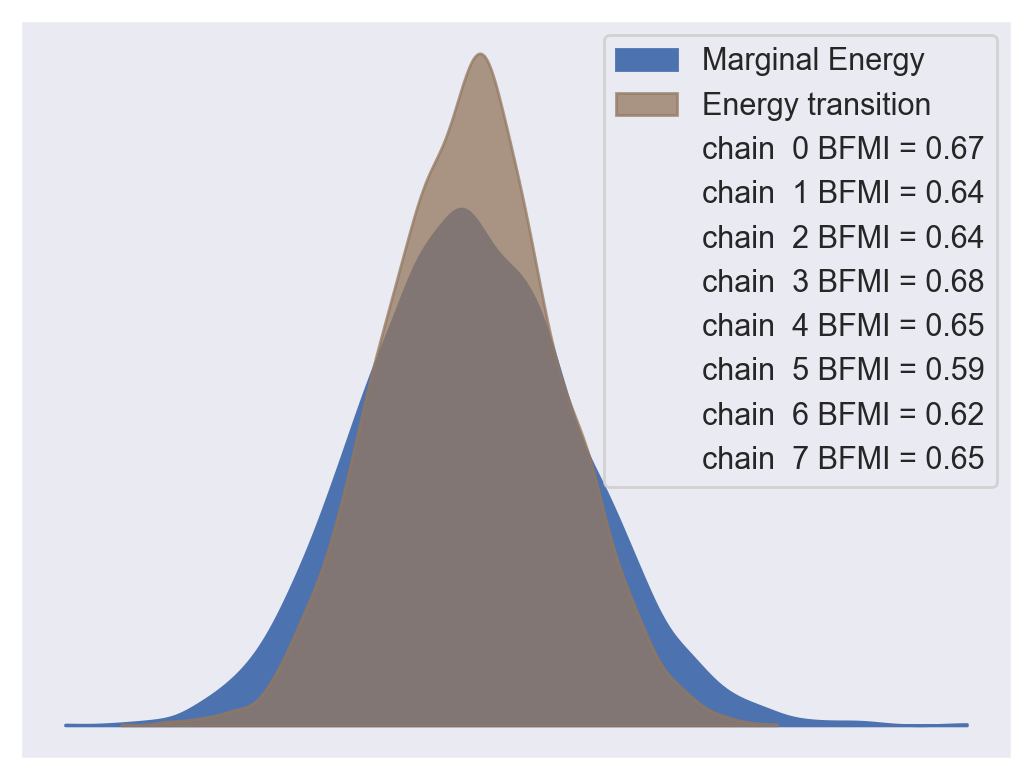

In [19]:
az.plot_energy(reg_trace);

We now examine how well the posterior distribution has recovered the true parameters, starting by visualizing the posterior distributions of the non-zero and zero coefficients separately.

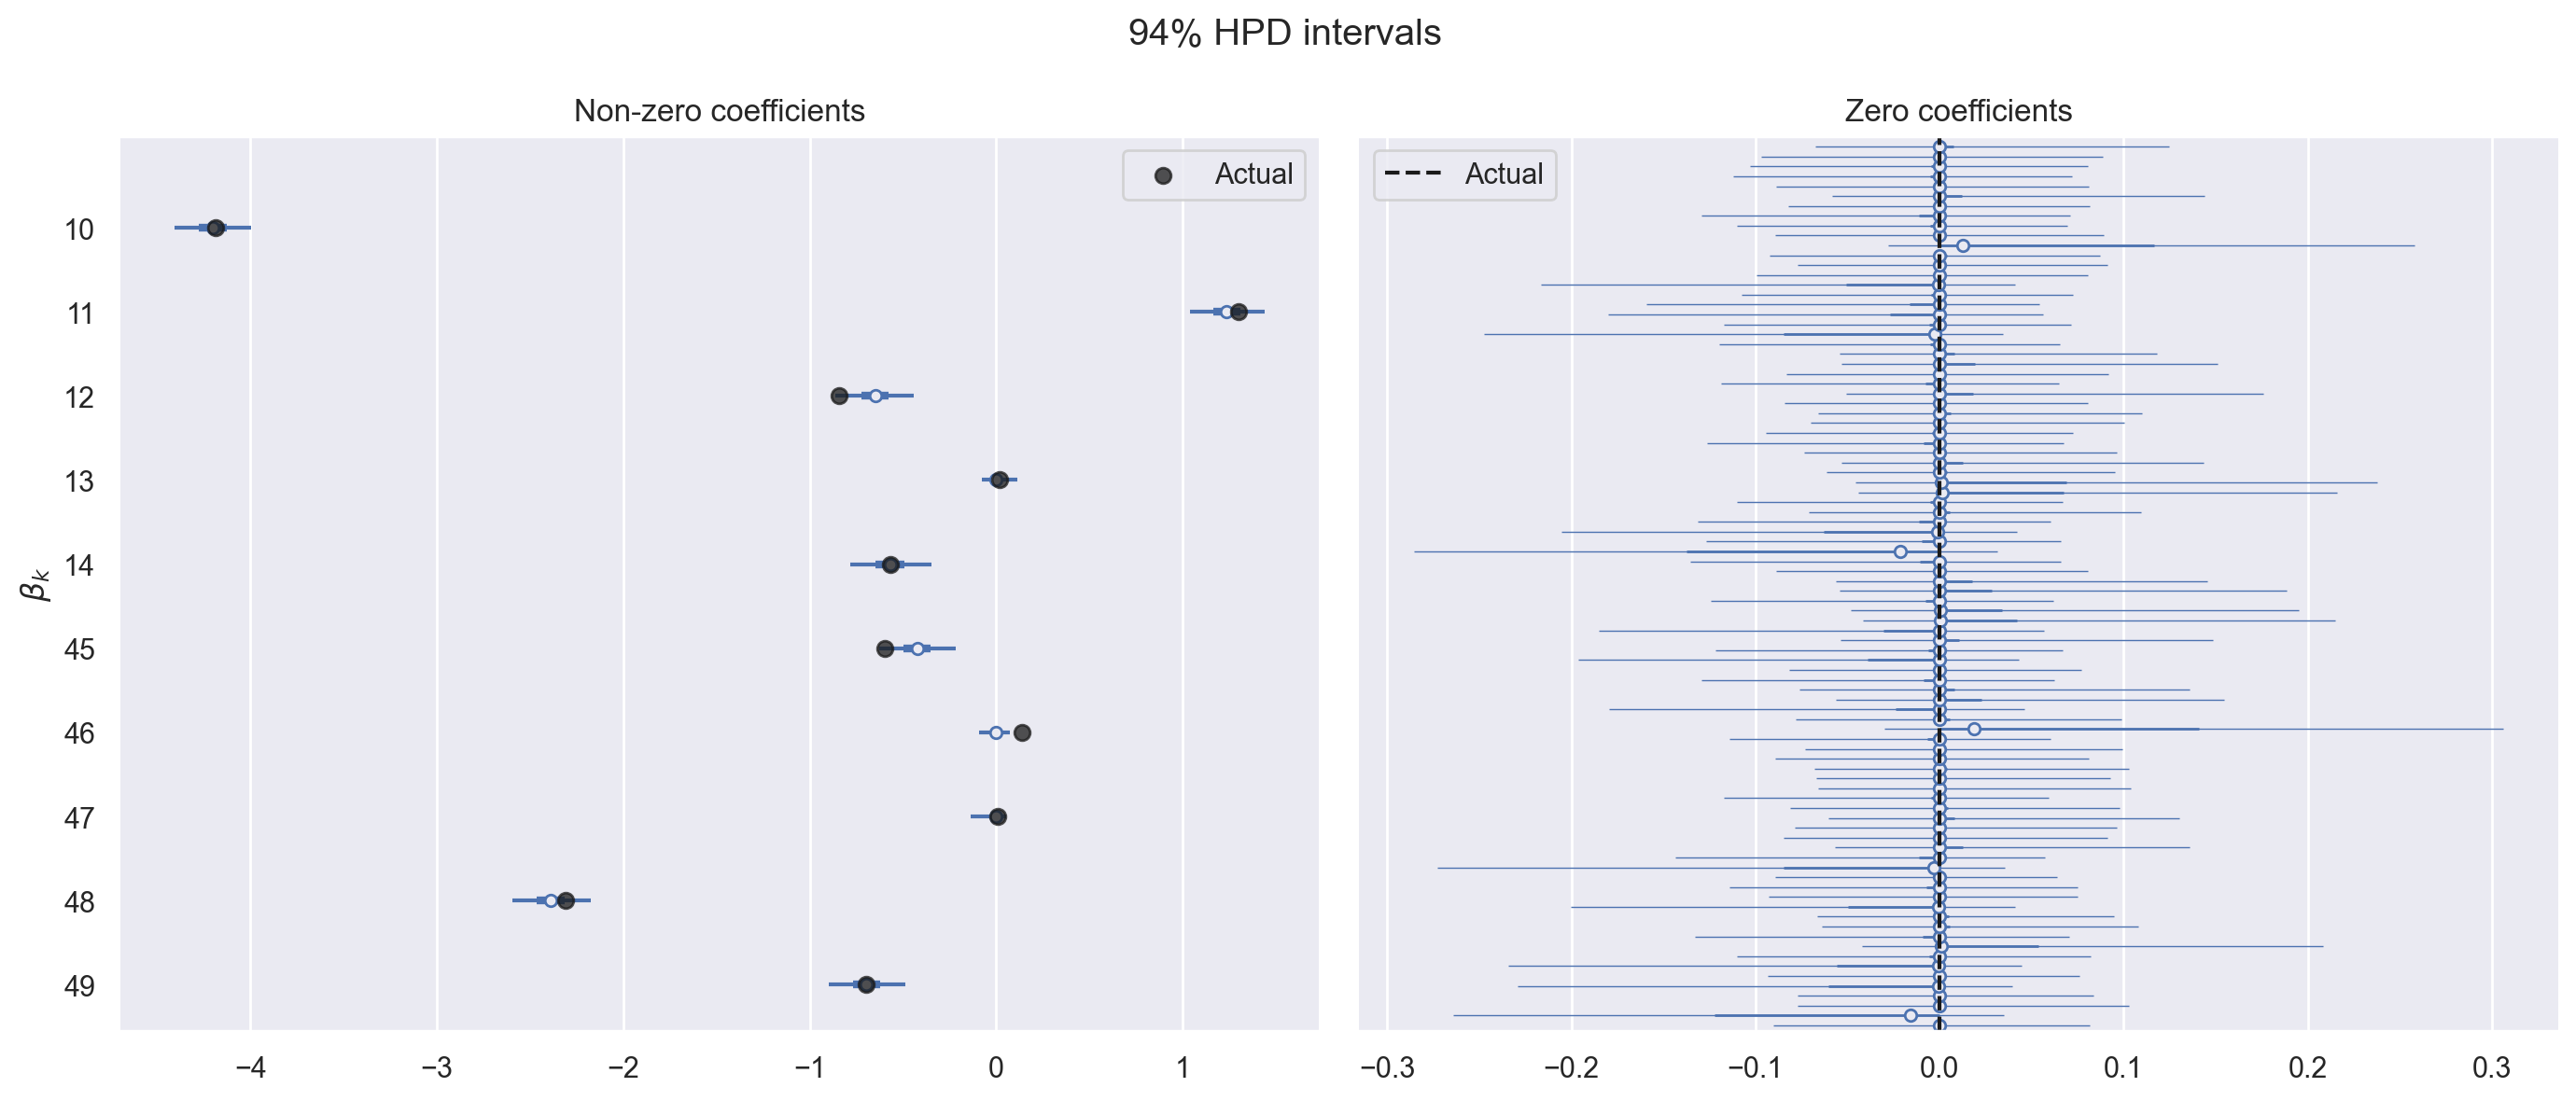

In [20]:
fig, (nz_ax, z_ax) = plt.subplots(figsize=(14, 6), ncols=2)

az.plot_forest(
    reg_trace,
    var_names="β",
    coords={"coef": np.flatnonzero(reg_coef)},
    combined=True,
    ax=nz_ax,
)

nz_ax.scatter(
    reg_coef[reg_coef != 0],
    nz_ax.get_yticks()[::-1],
    c="k",
    alpha=0.75,
    zorder=2,
    label="Actual",
)

nz_ax.set_yticklabels(np.flatnonzero(reg_coef)[::-1])
nz_ax.set_ylabel(r"$\beta_k$")

nz_ax.legend()
nz_ax.set_title("Non-zero coefficients")

az.plot_forest(
    reg_trace,
    var_names="β",
    coords={"coef": np.arange(P_REG)[reg_coef == 0]},
    combined=True,
    linewidth=0.5,
    ax=z_ax,
)

z_ax.axvline(0, c="k", ls="--", label="Actual")

z_ax.set_yticklabels([])

z_ax.legend(loc="upper left")
z_ax.set_title("Zero coefficients")

fig.suptitle("94% HPD intervals")
fig.tight_layout();

We see that, for all coefficients, the true value lies well within the 94% high posterior density intervals.

Though we will not go deeper in this post, the R2D2 paper compares performance of this prior to other popular high-dimensional regression priors in a variety of synthetic and real data situations.

## The ARR2 prior for autoregressive timeseries

The ARR2 prior adapts the ideas from the R2D2 prior to [autoregressive timeseries models](https://en.wikipedia.org/wiki/Autoregressive_model).  As in the previous section, we will first generate synthetic data before implementing the ARR2 model in PyMC.

The ARR2 paper tests this prior against three types of $\text{AR}(8)$ data generating processes (DGPs) commonly found in the timeseries modeling literature: Minnesota, dampened oscillations, and delayed relevance. The parameters for each of these DGPs are shown below.

In [21]:
AR_COEF = {
    "Minnesota": np.array([0.6, 0.15, 0.067, 0.038, 0.024, 0.017, 0.012, 0.009]),
    "Dampened oscillations": np.array(
        [-0.509, 0.582, -0.069, -0.309, 0.242, 0.031, -0.166, 0.089]
    ),
    "Delayed relevance": np.array([0, 0, 0, 0, 0.7, 0.2, 0.05, 0.025]),
}

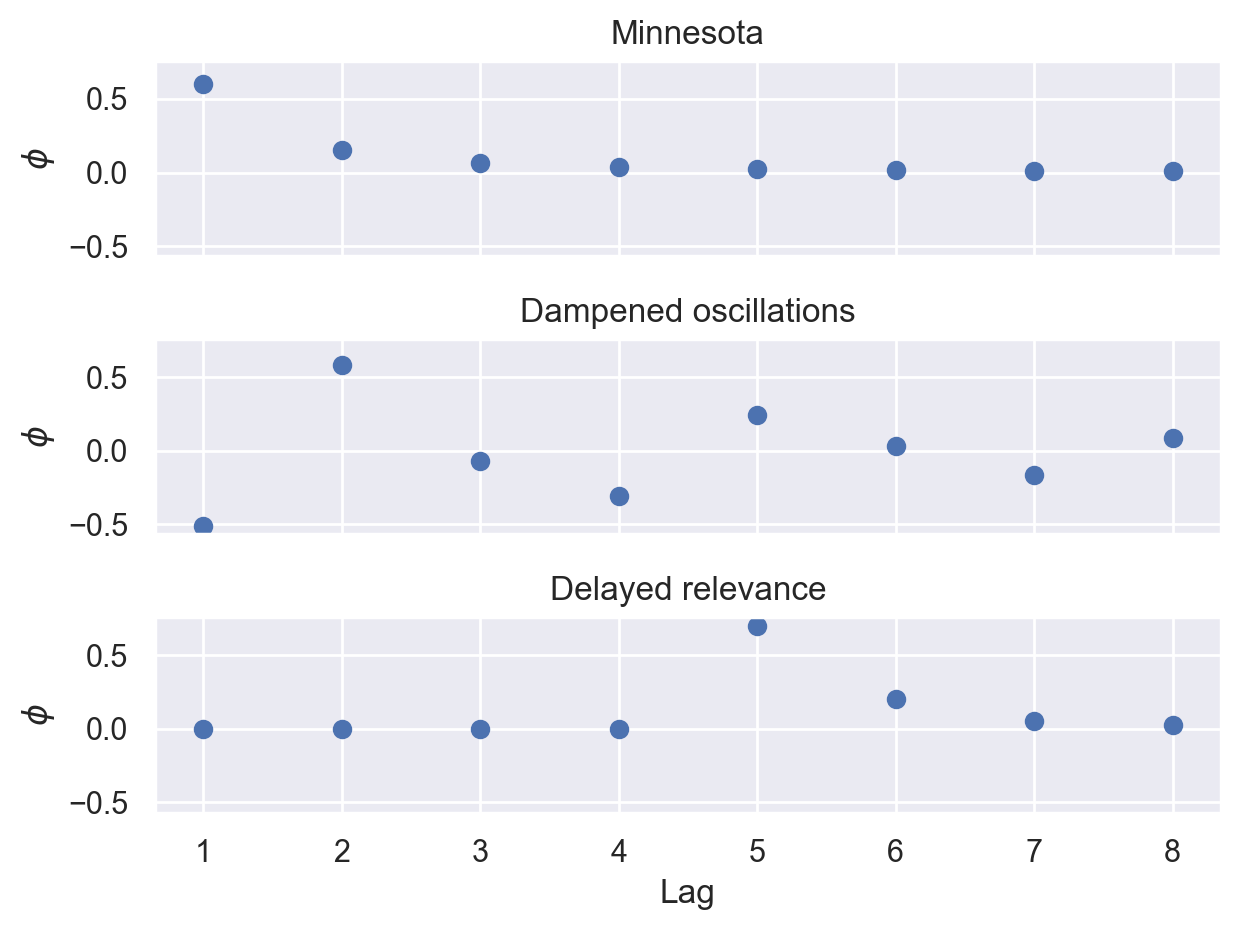

In [22]:
fig, axes = plt.subplots(nrows=len(AR_COEF), sharex=True, sharey=True)

for ax, (name, coef) in zip(axes, AR_COEF.items()):
    ax.scatter(1 + np.arange(coef.size), coef)

    ax.set_ylabel(r"$\phi$")
    ax.set_title(name)

ax.set_xlabel("Lag")

fig.tight_layout();

* The Minnesota DGP shows the strongest autocorrelation with the most recent predecessor in the series, with autocorrelation decreasing as lag increases.  This type of DGP is common in econometric applications.
* The dampened oscillations DTGP alternates between negative and positive autocorrelations as lag increases, with the magnitude of autocorrelation decreasing as lag increases.  This type of DGP is common in physical applications.
* The delayed relevance DGP resembles the Minnesota DGP, but with the initial high autocorrelation delayed four periods.  This type of DGP is also common in econometric applications.

The following function generates data from an autogregressive process with lag coefficients $\phi_1, \ldots \phi_p$ and innovation scale $\sigma$.

In [23]:
def generate_ar_data(ϕ, σ, t, n, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    p = ϕ.size
    y_ext = rng.normal(0, σ, (n, p + t))

    for s in range(t):
        y_ext[:, p + s] += y_ext[:, s : p + s].dot(ϕ[::-1])

    return y_ext[:, p:]

Below we generate one timeseries from each of these DGPs for illustrative purposes.

In [24]:
T = 120
SIGMA_AR = 1

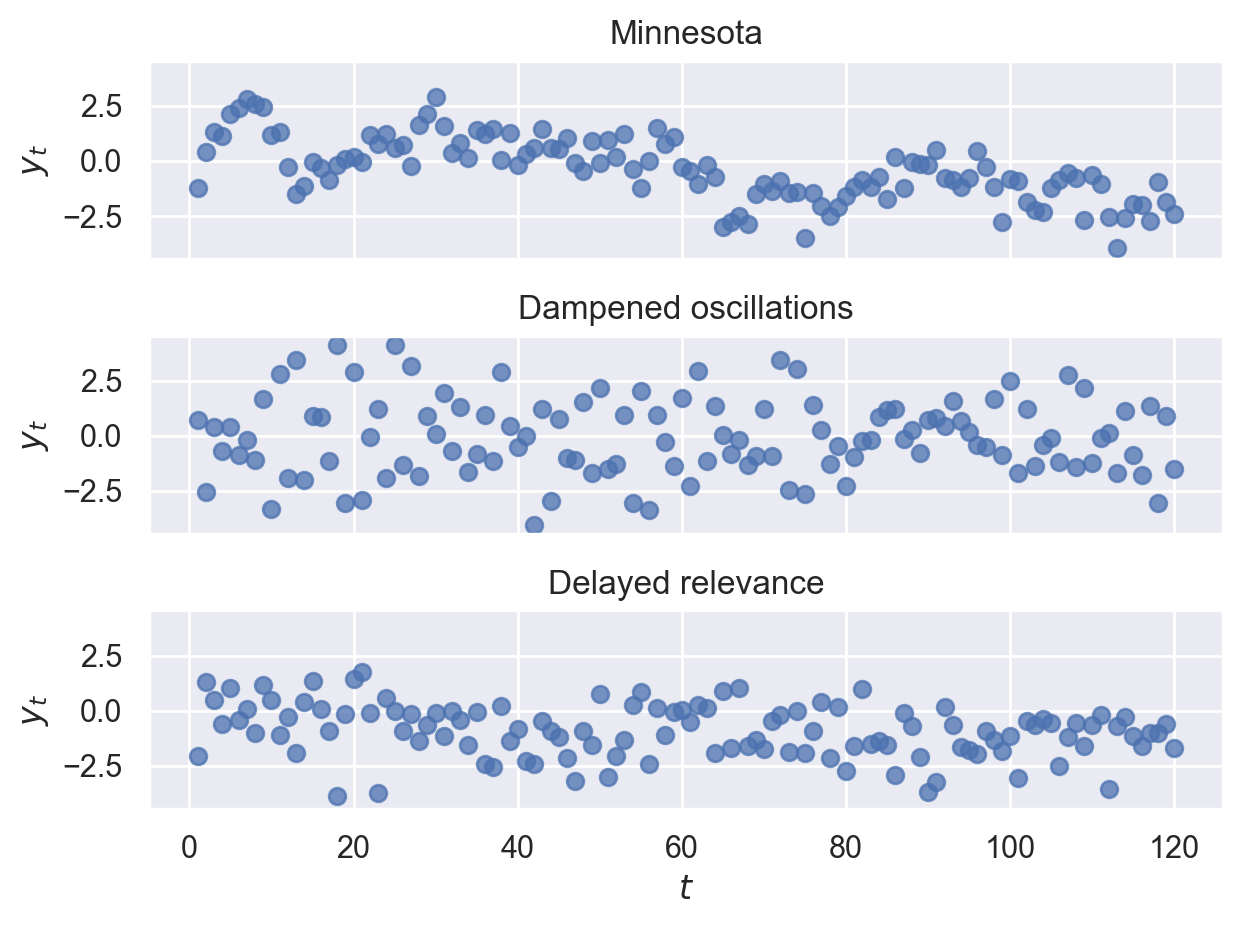

In [25]:
fig, axes = plt.subplots(nrows=len(AR_COEF), sharex=True, sharey=True)

for ax, (name, coef) in zip(axes, AR_COEF.items()):
    ax.scatter(
        1 + np.arange(T), generate_ar_data(coef, SIGMA_AR, T, 1, rng=rng), alpha=0.75
    )

    ax.set_ylabel("$y_t$")
    ax.set_title(name)

ax.set_xlabel("$t$")

fig.tight_layout();

We now generate $n = 10$ samples from each of these three DGPs.

In [26]:
N_AR = 10

In [27]:
ar_data = {
    name: generate_ar_data(coef, SIGMA_AR, T, N_AR, rng=rng)
    for name, coef in AR_COEF.items()
}

With this synthetic data, we are ready to implement the ARR2 prior in PyMC. As in the R2D2 prior, we use a prior $R^2 \sim \text{Beta}(\mu = \frac{1}{3}, \nu=3)$ on the coefficient of determination to set the global shrinkage and define 

$$\tau^2 = \frac{R^2}{1 - R^2}.$$

Note that the ARR2 paper denotes by $\tau^2$ for the quantity that the R2D2 paper denotes by $\omega$.  We will follow the notation of the ARR2 paper in this section.

In [28]:
P_MODEL = 30

In [29]:
with pm.Model(coords={"lag": 1 + np.arange(P_MODEL)}) as ar_model:
    R2 = pm.Beta("R2", mu=1 / 3, nu=3)
    τ2 = R2 / (1 - R2)

A Dirichlet distribution is used to bridge between global and local regularization again.

In [30]:
with ar_model:
    ψ = pm.Dirichlet("ψ", 0.1 * np.ones(P_MODEL), dims="lag")
    σ = pm.HalfNormal("σ", HALFNORMAL_SCALE)

A difference between the R2D2 and ARR2 priors arises when defining the local scale of the prior for each coefficient.  For the ARR2 prior, we use

$$\phi_k \sim N\left(0, \frac{\sigma^2}{\sigma_{y\ | \Theta}^2} \cdot \tau^2 \psi_k\right).$$

Here we use $\Theta$ to denote the full set of parameters of the model.  In general $\sigma_{y\ | \Theta}^2$ can be challenging to incorporate into the model, so following the ARR2 paper, we take an [empirical Bayes](https://en.wikipedia.org/wiki/Empirical_Bayes_method) approach by using the observed sample variance of $y_t$ in its place.  As in the R2D2 section, we use a non-centered parameterization for the prior on the coeffficients.

In [31]:
with ar_model:
    y = pm.Data("y", ar_data["Minnesota"])

    Δ_ϕ = pm.Normal("Δ_ϕ", 0, 1, dims="lag")
    σ_ϕ = σ / y.std() * pt.sqrt(τ2 * ψ)
    ϕ = pm.Deterministic("ϕ", Δ_ϕ * σ_ϕ, dims="lag")

Finally we define the autoregressive likelihood given these parameters.

In [32]:
with ar_model:
    pm.AR(
        "obs",
        ϕ,
        np.sqrt(2) * σ,
        init_dist=pm.Normal.dist(0, 1, shape=P_MODEL),
        observed=y,
    )

We now sample from the posterior distribution of this model.  Note that we have, for the moment, set the observed data to be the samples from the Minnesota DGP.

In [33]:
ar_traces = {
    "Minnesota": nutpie.sample(
        nutpie.compile_pymc_model(ar_model), target_accept=0.95, **SAMPLER_KWARGS
    )
}

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,2,0.02,511
,1300,4,0.02,511
,1300,3,0.02,511
,1300,3,0.02,1023
,1300,1,0.02,1023
,1300,0,0.02,1023
,1300,1,0.02,511
,1300,0,0.02,511


In spite of a few divergences in each chain, the $\hat{R}$ statistics and energy plot for the samples show no cause for concern.

In [34]:
az.rhat(ar_traces["Minnesota"]).max()

<xarray.Dataset> Size: 64B
Dimensions:       ()
Data variables:
    R2_logodds__  float64 8B 1.003
    ψ_simplex__   float64 8B 1.012
    σ_log__       float64 8B 1.001
    Δ_ϕ           float64 8B 1.003
    R2            float64 8B 1.003
    ψ             float64 8B 1.009
    σ             float64 8B 1.001
    ϕ             float64 8B 1.003

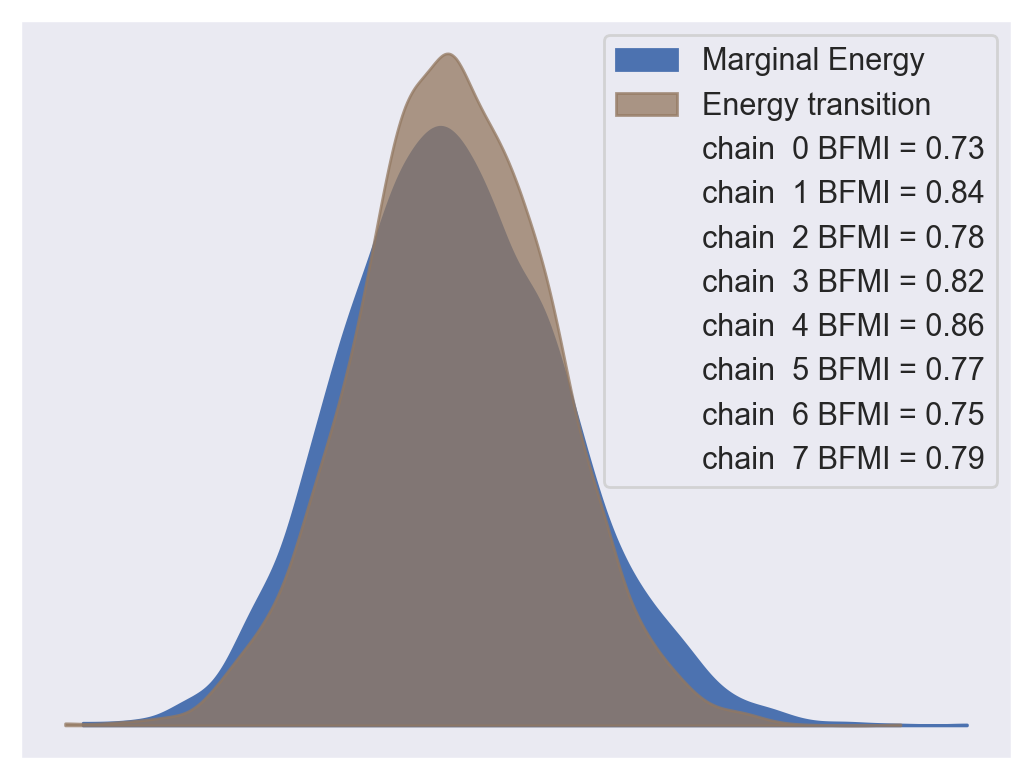

In [35]:
az.plot_energy(ar_traces["Minnesota"]);

We now examine how well the posterior distribution has recovered the true parameters, starting by visualizing the posterior distributions of the non-zero coefficients.

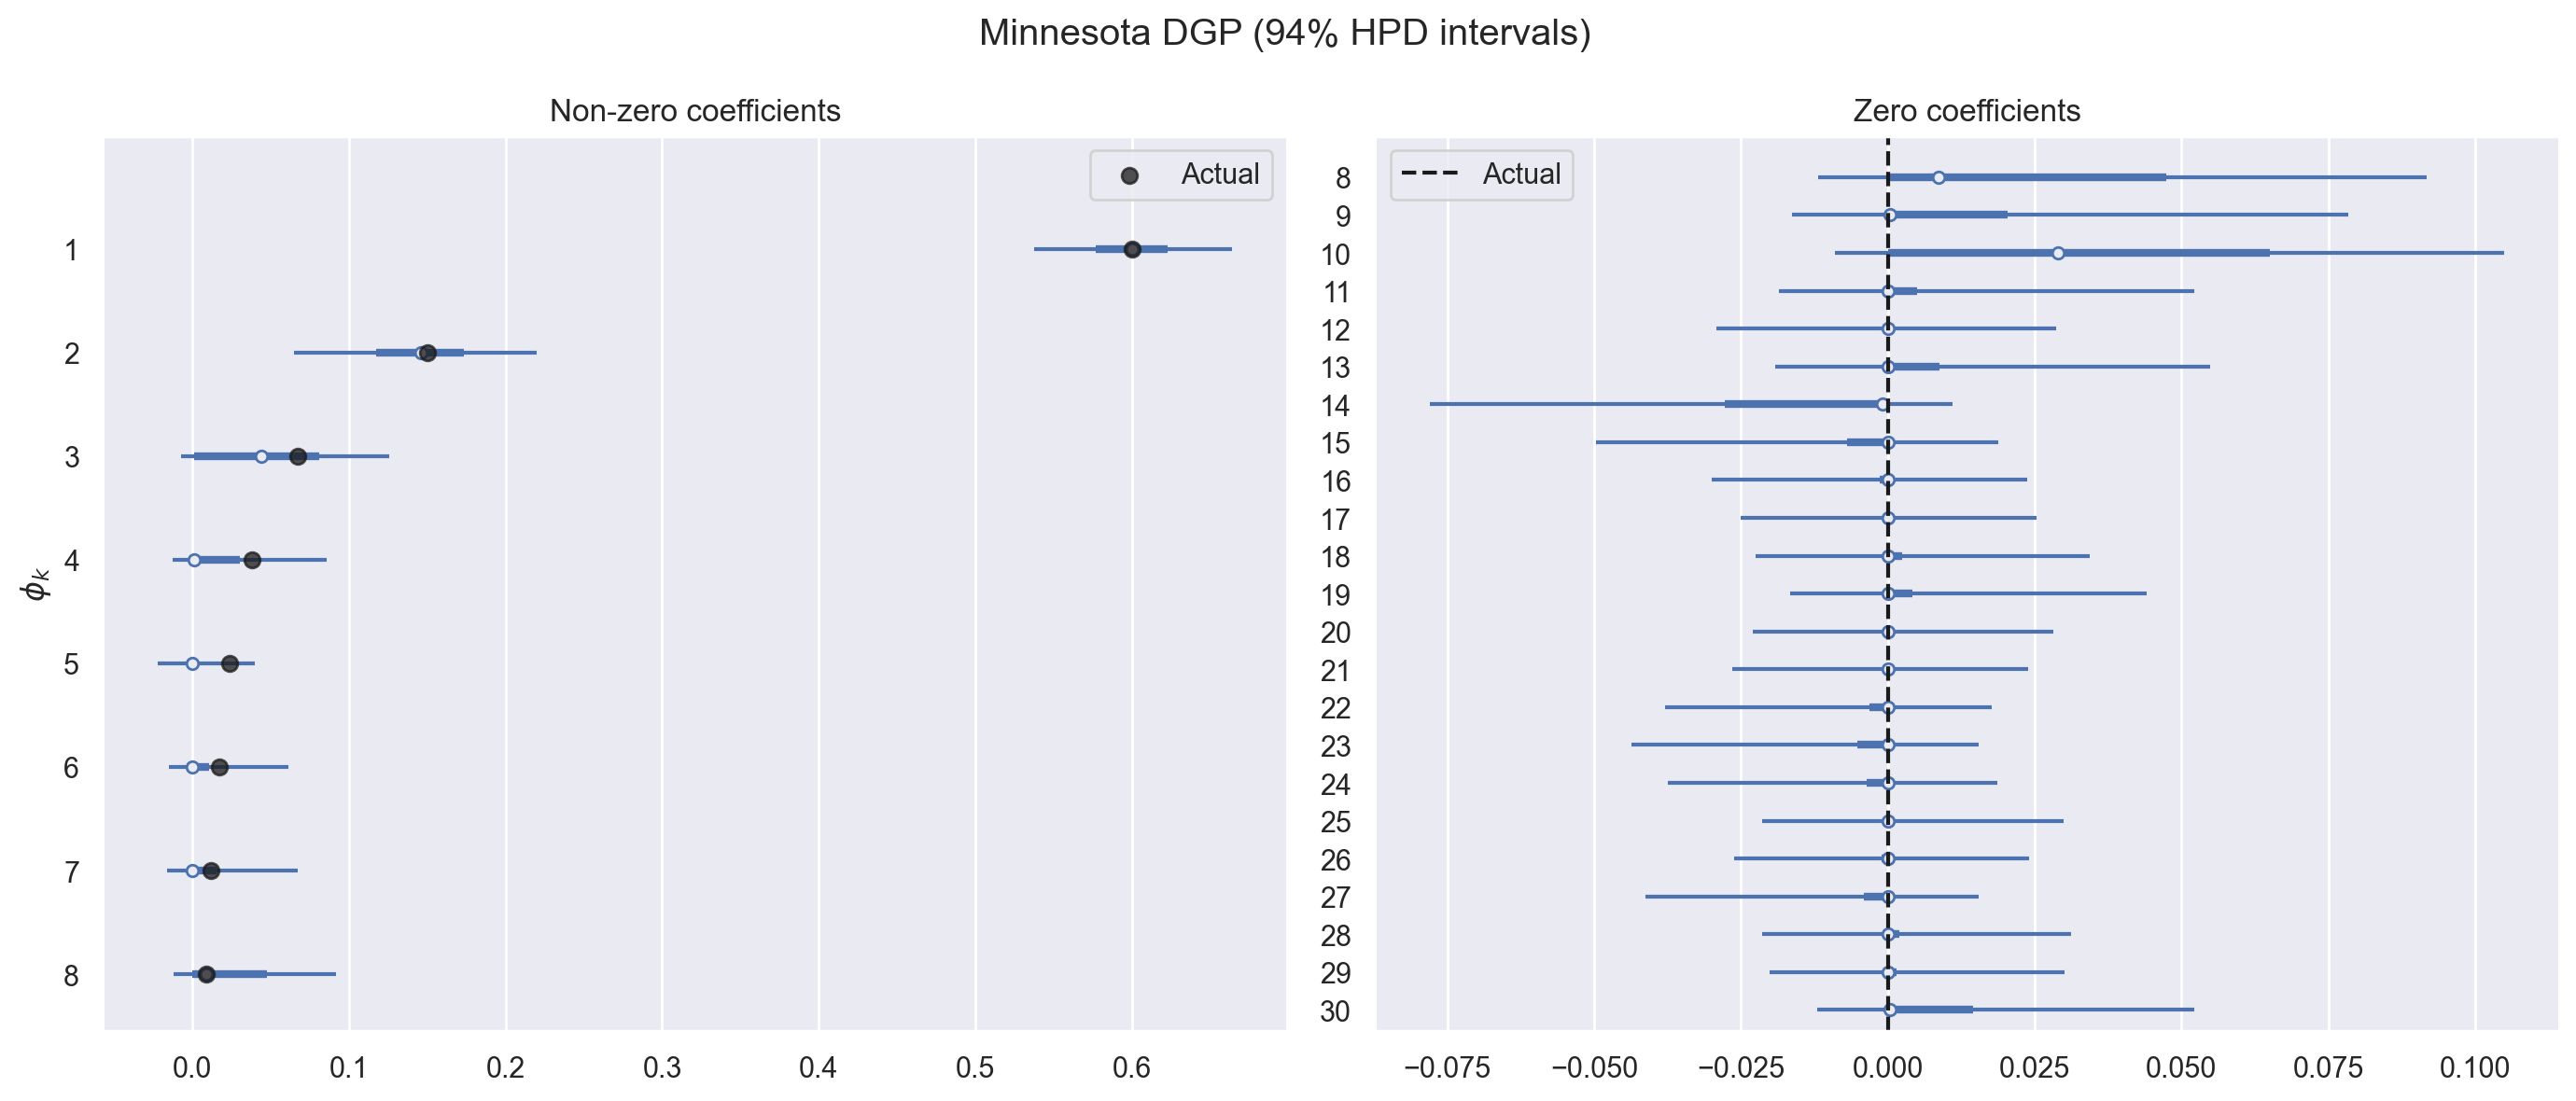

In [36]:
fig, (nz_ax, z_ax) = plt.subplots(figsize=(14, 6), ncols=2)

name = "Minnesota"

az.plot_forest(
    ar_traces[name],
    var_names="ϕ",
    coords={"lag": 1 + np.arange(AR_COEF[name].size)},
    combined=True,
    ax=nz_ax,
)

nz_ax.scatter(
    AR_COEF[name],
    nz_ax.get_yticks()[::-1],
    c="k",
    alpha=0.75,
    zorder=2,
    label="Actual",
)

nz_ax.set_yticklabels(1 + np.arange(AR_COEF[name].size)[::-1])
nz_ax.set_ylabel(r"$\phi_k$")

nz_ax.legend()
nz_ax.set_title("Non-zero coefficients")

az.plot_forest(
    ar_traces[name],
    var_names="ϕ",
    coords={"lag": np.arange(AR_COEF[name].size, P_MODEL + 1)},
    combined=True,
    ax=z_ax,
)

z_ax.axvline(0, c="k", ls="--", label="Actual")

z_ax.set_yticklabels(np.arange(AR_COEF[name].size, P_MODEL + 1)[::-1])

z_ax.legend(loc="upper left")
z_ax.set_title("Zero coefficients")

fig.suptitle(f"{name} DGP (94% HPD intervals)")
fig.tight_layout();

We see that, for all coefficients, the true value lies well within the 94% high posterior density intervals.

We now repeat this validation for the two other DGPs.

In [37]:
with ar_model:
    pm.set_data({"y": ar_data["Dampened oscillations"]})

ar_traces["Dampened oscillations"] = nutpie.sample(
    nutpie.compile_pymc_model(ar_model), target_accept=0.95, **SAMPLER_KWARGS
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,2,0.02,511
,1300,2,0.02,511
,1300,0,0.02,1023
,1300,2,0.02,511
,1300,6,0.02,511
,1300,4,0.02,511
,1300,1,0.02,1023
,1300,4,0.02,1023


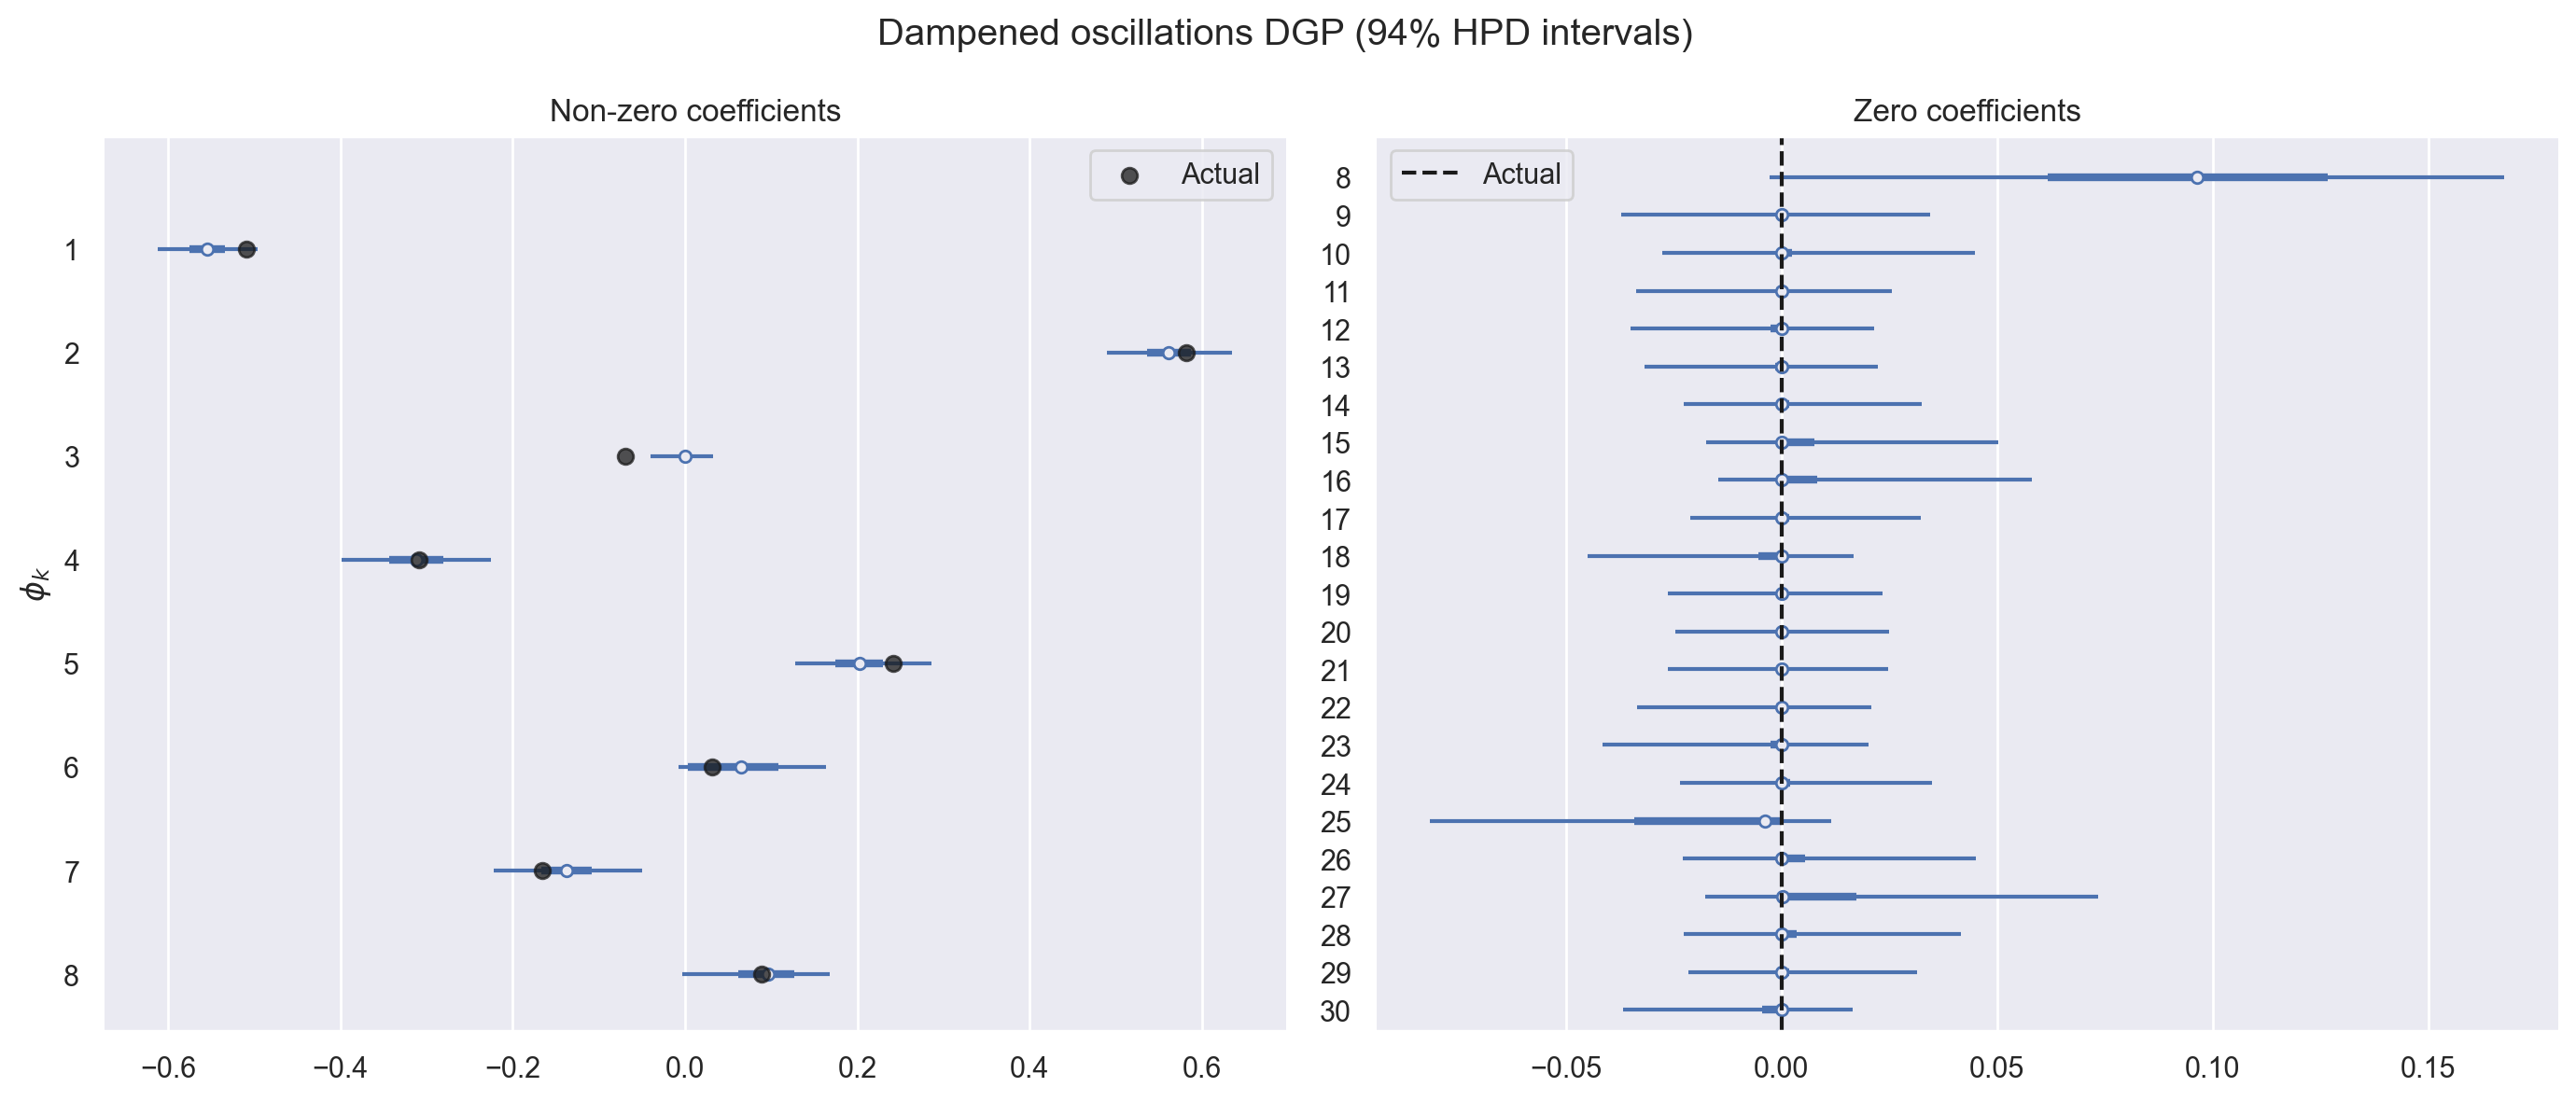

In [38]:
fig, (nz_ax, z_ax) = plt.subplots(figsize=(14, 6), ncols=2)

name = "Dampened oscillations"

az.plot_forest(
    ar_traces[name],
    var_names="ϕ",
    coords={"lag": 1 + np.arange(AR_COEF[name].size)},
    combined=True,
    ax=nz_ax,
)

nz_ax.scatter(
    AR_COEF[name],
    nz_ax.get_yticks()[::-1],
    c="k",
    alpha=0.75,
    zorder=2,
    label="Actual",
)

nz_ax.set_yticklabels(1 + np.arange(AR_COEF[name].size)[::-1])
nz_ax.set_ylabel(r"$\phi_k$")

nz_ax.legend()
nz_ax.set_title("Non-zero coefficients")

az.plot_forest(
    ar_traces[name],
    var_names="ϕ",
    coords={"lag": np.arange(AR_COEF[name].size, P_MODEL + 1)},
    combined=True,
    ax=z_ax,
)

z_ax.axvline(0, c="k", ls="--", label="Actual")

z_ax.set_yticklabels(np.arange(AR_COEF[name].size, P_MODEL + 1)[::-1])

z_ax.legend(loc="upper left")
z_ax.set_title("Zero coefficients")

fig.suptitle(f"{name} DGP (94% HPD intervals)")
fig.tight_layout();

We see that, for almost all coefficients, the true value for the dampened oscillations DGP lies well within the 94% high posterior density intervals.

In [39]:
with ar_model:
    pm.set_data({"y": ar_data["Delayed relevance"]})

ar_traces["Delayed relevance"] = nutpie.sample(
    nutpie.compile_pymc_model(ar_model), target_accept=0.95, **SAMPLER_KWARGS
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,4,0.02,1023
,1300,4,0.02,1023
,1300,1,0.02,511
,1300,0,0.02,511
,1300,4,0.02,1023
,1300,6,0.02,1023
,1300,3,0.02,511
,1300,6,0.02,1023


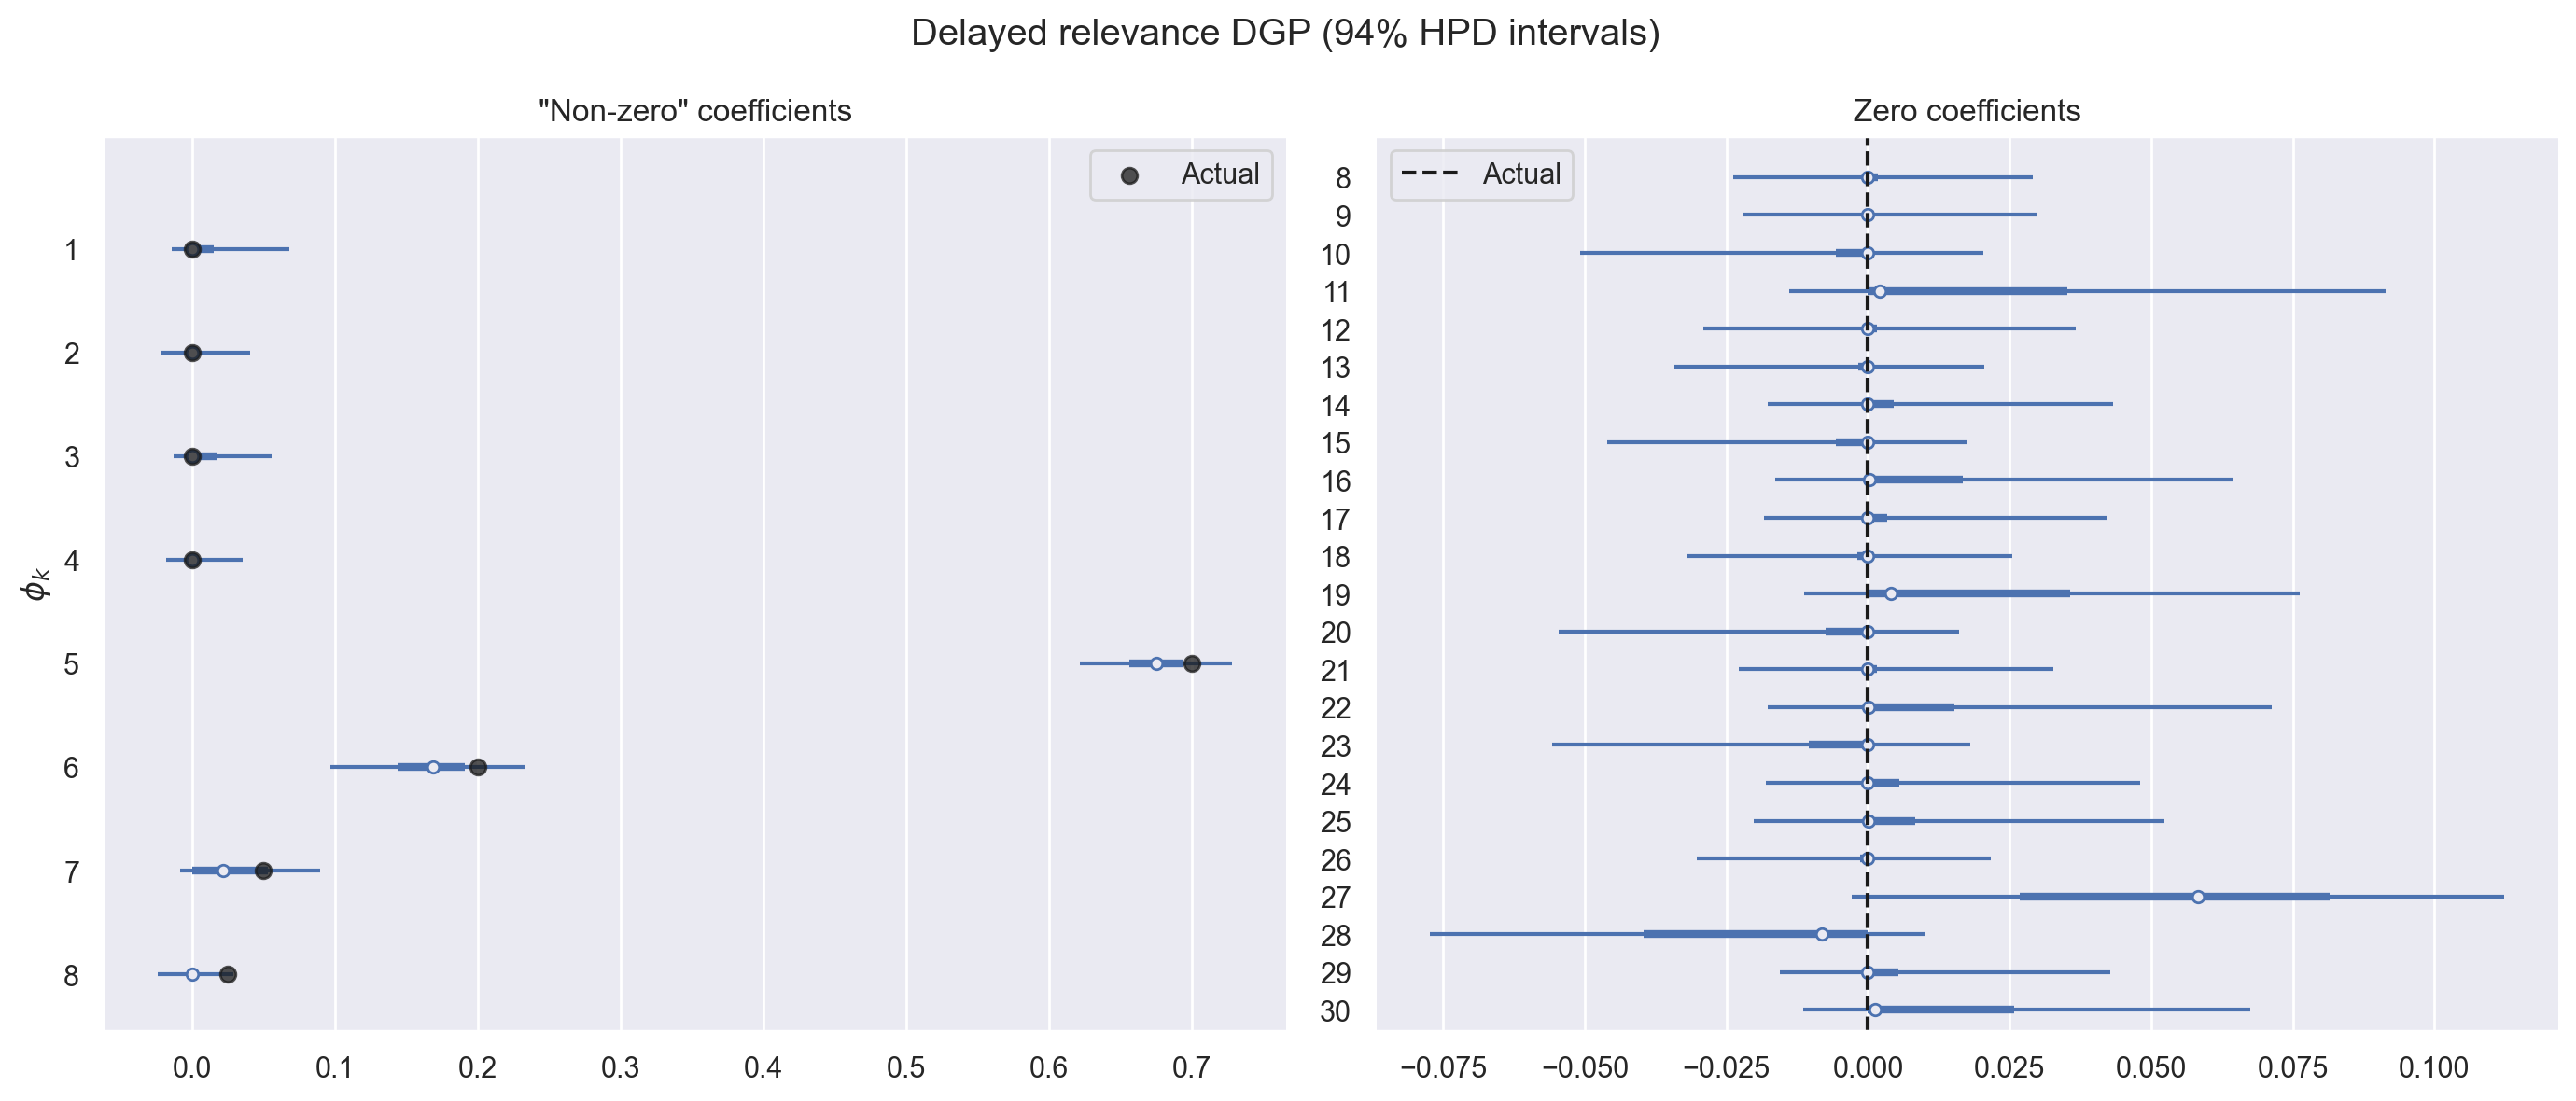

In [40]:
fig, (nz_ax, z_ax) = plt.subplots(figsize=(14, 6), ncols=2)

name = "Delayed relevance"

az.plot_forest(
    ar_traces[name],
    var_names="ϕ",
    coords={"lag": 1 + np.arange(AR_COEF[name].size)},
    combined=True,
    ax=nz_ax,
)

nz_ax.scatter(
    AR_COEF[name],
    nz_ax.get_yticks()[::-1],
    c="k",
    alpha=0.75,
    zorder=2,
    label="Actual",
)

nz_ax.set_yticklabels(1 + np.arange(AR_COEF[name].size)[::-1])
nz_ax.set_ylabel(r"$\phi_k$")

nz_ax.legend()
nz_ax.set_title('"Non-zero" coefficients')

az.plot_forest(
    ar_traces[name],
    var_names="ϕ",
    coords={"lag": np.arange(AR_COEF[name].size, P_MODEL + 1)},
    combined=True,
    ax=z_ax,
)

z_ax.axvline(0, c="k", ls="--", label="Actual")

z_ax.set_yticklabels(np.arange(AR_COEF[name].size, P_MODEL + 1)[::-1])

z_ax.legend(loc="upper left")
z_ax.set_title("Zero coefficients")

fig.suptitle(f"{name} DGP (94% HPD intervals)")
fig.tight_layout();

We see that, for all coefficients, the true value for the delayed relevance DGP lies well within the 94% high posterior density intervals.  Note that for this DGP we have taken a bit of liberty with the term "non-zero coefficients," in that the first four lag coefficients are zero, but we include them in the left plot anyway, as they are followed by nonzero coefficients. 

As in the prior section, the ARR2 paper compares performance of this prior to other popular autoregressive timeseries priors in a variety of synthetic and real data situations.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/f720f0888ee31e8b893278cf2f46918b).

In [41]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Fri Mar 07 2025

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

nutpie    : 0.13.2
matplotlib: 3.9.2
scipy     : 1.14.1
arviz     : 0.20.0
seaborn   : 0.13.2
pymc      : 5.18.2
pytensor  : 2.26.3
numpy     : 1.26.4

